In [12]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
# Dataset exploring
import os

In [13]:
# Dataset generation
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
# Transfert learning
from keras.applications import VGG16
# Optimizer
from keras.optimizers import Adam
# Keras layers
from keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
# Keras model
from keras.models import Model

In [3]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk(r'C:/Users/hp/Downloads/Rotten_Fruit_Detection_Dataset/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

freshapples     1693           
freshbanana     1581           
freshoranges    1466           
rottenapples    2342           
rottenbanana    2224           
rottenoranges   1595           


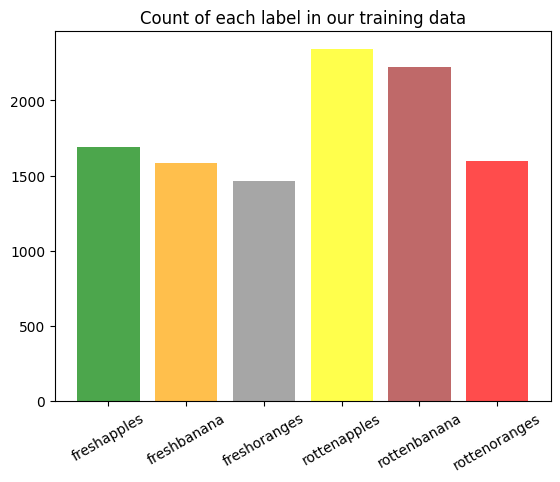

In [4]:
counts = []
labels = []
for d in classes:
    [(k, v)] = d.items()
    labels.append(k)
    counts.append(v)

plt.figure()
plt.bar(range(len(counts)), counts, color = ['green', 'orange', 'grey', 'yellow', 'brown', 'red'], alpha = .7)
plt.xticks(range(len(counts)), labels, rotation = 30)
plt.title('Count of each label in our training data')
plt.show()

In [5]:
TRAIN_PATH = r'C:\Users\hp\Downloads\Rotten_Fruit_Detection_Dataset\dataset\train'
TEST_PATH = r'C:\Users\hp\Downloads\Rotten_Fruit_Detection_Dataset\dataset\test'

In [6]:
datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = .3, 
    horizontal_flip = True, 
    vertical_flip = True, 
    validation_split = .3
)

train_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'training'
)

validation_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'validation'
)

Found 7634 images belonging to 6 classes.
Found 3267 images belonging to 6 classes.


In [7]:
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
vgg16.trainable = False

In [8]:
X_input = Input(shape = (256, 256, 3))
X = vgg16(X_input)
X = AveragePooling2D(pool_size = (3, 3), strides = 2, padding = 'valid',name = 'AvgPool2D')(X)
X = Flatten(name = 'Flatten')(X)
X = Dense(200, activation = 'relu', name = 'Dense1')(X)
X = Dropout(.1)(X)
X = Dense(100, activation = 'relu', name = 'Dense2')(X)
X = Dropout(.1)(X)
X = Dense(6, activation = 'softmax', name = 'Dense3')(X)

model = Model(inputs = X_input, outputs = X, name = 'Fruit_Classifer')

print(model.summary())

Model: "Fruit_Classifer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 AvgPool2D (AveragePooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 Dense1 (Dense)              (None, 200)               921800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                   

In [9]:
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_weights.h5', save_best_only=True)
hist = model.fit(train_ds, validation_data=validation_ds, epochs=1, batch_size=32, callbacks=[checkpoint])


239/239 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.8217 

C:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


239/239 [==============================] - 4522s 19s/step - loss: 0.8452 - accuracy: 0.8217 - val_loss: 0.1737 - val_accuracy: 0.9418


In [10]:
model.save('Rotten_fruit_detection_model.h5')

1/1 [==============================] - 1s 1s/step


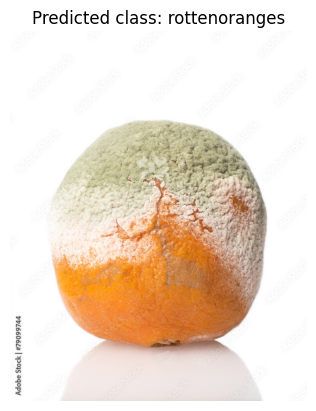

Predicted class: rottenoranges
Predicted probabilities: [7.8083031e-06 7.6936113e-10 4.2330455e-03 1.7639587e-06 1.9532980e-07
 9.9575716e-01]


In [27]:
import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the model without weights
model = keras.models.load_model(r"Rotten_fruit_detection_model.h5", compile=False)

# Define the new input shape
new_input_shape = (256, 256, 3)

# Create a new VGG16 model with the modified input shape
new_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=new_input_shape)
new_vgg16.trainable = False  # Set VGG16 to be non-trainable

# Build a new model by combining the new VGG16 and the remaining part of the original model
new_model = keras.models.Sequential([
    new_vgg16,
    model.get_layer('AvgPool2D'),  # Replace with the actual layer name from your model
    model.get_layer('Flatten'),    # Replace with the actual layer name from your model
    model.get_layer('Dense1'),     # Replace with the actual layer name from your model
    model.get_layer('dropout'),    # Replace with the actual layer name from your model
    model.get_layer('Dense2'),     # Replace with the actual layer name from your model
    model.get_layer('dropout_1'),  # Replace with the actual layer name from your model
    model.get_layer('Dense3')      # Replace with the actual layer name from your model
])

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the new image and resize it to (256, 256)
new_image_path = r"C:\Users\hp\Downloads\R_orange.jpg"
img = image.load_img(new_image_path, target_size=new_input_shape[:2])
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = new_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())  # Assuming train_ds is defined somewhere in your code
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


1/1 [==============================] - 1s 995ms/step


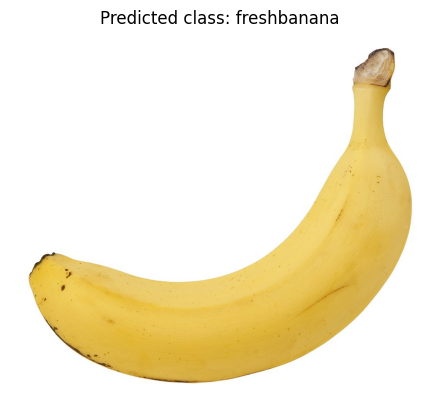

Predicted class: freshbanana
Predicted probabilities: [1.00224044e-10 1.00000000e+00 7.40656017e-13 1.79729147e-15
 4.30133679e-10 1.96849644e-13]


In [28]:
import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the model without weights
model = keras.models.load_model(r"Rotten_fruit_detection_model.h5", compile=False)

# Define the new input shape
new_input_shape = (256, 256, 3)

# Create a new VGG16 model with the modified input shape
new_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=new_input_shape)
new_vgg16.trainable = False  # Set VGG16 to be non-trainable

# Build a new model by combining the new VGG16 and the remaining part of the original model
new_model = keras.models.Sequential([
    new_vgg16,
    model.get_layer('AvgPool2D'),  # Replace with the actual layer name from your model
    model.get_layer('Flatten'),    # Replace with the actual layer name from your model
    model.get_layer('Dense1'),     # Replace with the actual layer name from your model
    model.get_layer('dropout'),    # Replace with the actual layer name from your model
    model.get_layer('Dense2'),     # Replace with the actual layer name from your model
    model.get_layer('dropout_1'),  # Replace with the actual layer name from your model
    model.get_layer('Dense3')      # Replace with the actual layer name from your model
])

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the new image and resize it to (256, 256)
new_image_path = r"C:\Users\hp\Downloads\Banana-Single.jpg"
img = image.load_img(new_image_path, target_size=new_input_shape[:2])
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = new_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())  # Assuming train_ds is defined somewhere in your code
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')
